## Evaluating layer-wise sources and sinks of o2 using wmt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import rebin_functions as rb
from xhistogram.xarray import histogram
# from xarrayutils import vertical_coordinates as vc

In [3]:
# Load the data
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '11'
filename = '08990101.ocean_daily.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename).squeeze()
filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)
# Grab rho2 interfaces from model output
# runname=''
# filename_rho2 = '08990101.ocean_month_rho2.nc'
# rho2_i = xr.open_dataset(rootdir+runname+'/history/'+filename_rho2).rho2_i
# rho2_l = xr.open_dataset(rootdir+runname+'/history/'+filename_rho2).rho2_l
# Name of vertical coordinate
vertc = 'zl'
rho0=ds['rhozero'].values
cp=ds['cpocean'].values

# SET EVERYTHING WITH ZERO THICKNESS TO NAN
# ds = ds.where(ds['thkcello']>0.001,np.nan)

# Budgets
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap',
            'o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']

# Close oxygen budget
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in o2_terms[:-1]:
    ds[term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds,o2_terms[1:],o2_terms[0],plot=False)
ds['o2_vdiffuse_impl']=error

# # SALT
# tendsum,error = bc.calc_budget(ds,salt_terms[1:],salt_terms[0],plot=True)
# ds['osaltdiff']=ds['osaltdiff']+error


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
# Prepare for water mass transformation calculations
# Calculate material derivative and diffusive terms
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
# HEAT
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# SALT
signsLHS = [-1,1,1]
signsRHS = [1,1,1]
termsLHS = salt_terms[:3]
termsRHS = salt_terms[3:]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# RHO
Dheat = -1*Dheat
Dsalt = -1*Dsalt

drho = (ds['drho_dT']/cp)*dheat+(ds['drho_dS']*ds['salt'])*dsalt

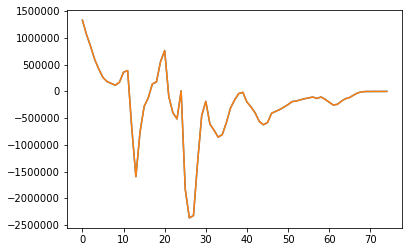

In [5]:
# O2
signsLHS = [1,-1,-1]
signsRHS = [1,1,1]
termsLHS = o2_terms[:3]
termsRHS = o2_terms[3:]
Do2, do2, error_o2 = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
x = -60
y = 20
plt.plot((Do2*grid.areacello).isel(time=1).sum(['xh','yh']))
plt.plot((do2*grid.areacello).isel(time=1).sum(['xh','yh']))
# plt.plot(do2.squeeze().sel(xh=x,yh=y,method='nearest'))

In [7]:
# Tracer content tendency
l = ds['temp_snap']
delta_l = 0.5
l_i_vals = np.arange(-2,30,delta_l)
c = ds['o2_snap']
h = ds['thkcello_snap']
area = grid.areacello
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
verbose=True

C_vals = np.zeros(shape=(len(l_l_vals),2))
for i in range(len(l_l_vals)):
    if verbose:
        print(i)
    mask_l = l>=l_l_vals[i]
    C_vals[i] = (rho0*c*h*area).where(mask_l,0).sum(['xh','yh','zl'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


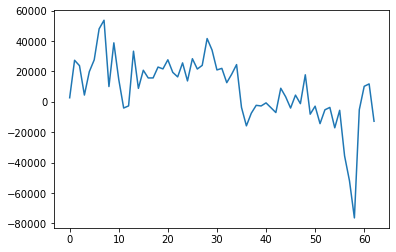

In [23]:
dt = 86400
dCdt = (C_vals[:,1]-C_vals[:,0])/dt
plt.plot(dCdt)

In [28]:
l = ds['temp']
dl = dheat/cp
delta_l = 0.5
l_i_vals = np.arange(-2,30,delta_l)
c = ds['o2']
# sumofterms = ds['o2h_tendency']+ds['o2_dfxy_cont_tendency']+ds['o2_vdiffuse_impl']+ds['jo2']
# sumofterms = ds['o2_advection_xy']+ds['o2h_tendency_vert_remap']
area = grid.areacello

# G = calc_G(l,dl,l_i_vals,area,plot=False)
E = calc_E(c,l,dl,l_i_vals,area,plot=False)
# A = calc_A(sumofterms,l,l_i_vals,area,plot=False,verbose=True)

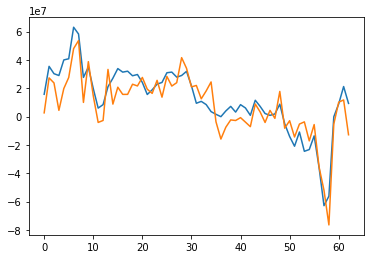

In [34]:
plt.plot(E.isel(time=1))
plt.plot(dCdt*1E3)

In [25]:
# Discrete volume calculation derived in Appendix 7.5 of Groeskamp et al (2018)
def calc_G(l,dl,l_i_vals,area,plot=False):
    # dl is the layer-integrated heat, salt, or density flux due to 'diffusive' processes
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    delta_l_vals = np.diff(l_i_vals)
    nanmask = np.isnan(dl)
    G = histogram(l.where(~nanmask),bins=[l_i_vals],weights=(dl*area).where(~nanmask),dim=['xh','yh','zl'],block_size=1)/delta_l_vals
    if plot:
        G.plot()
    return G

In [26]:
# Discrete volume calculation derived in Appendix 7.5 of Groeskamp et al (2018)
def calc_E(c,l,dl,l_i_vals,area,plot=False):
    # dl is the layer-integrated heat, salt, or density flux due to 'diffusive' processes
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    delta_l_vals = np.diff(l_i_vals)
    nanmask = np.isnan(dl)
    E = histogram(l.where(~nanmask),bins=[l_i_vals],weights=(c*dl*area).where(~nanmask),dim=['xh','yh','zl'],block_size=1)/delta_l_vals
    if plot:
        E.plot()
    return E

In [50]:
def calc_P(p,l,l_i_vals,area):
    # RANGE MUST INCLUDE ALL POSSIBLE VALUES OF l
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    nanmask = np.isnan(l)
    # Integrate p in each bin
    P_l = histogram(l.where(~nanmask),bins=[l_l_vals],weights=(p*area).where(~nanmask),dim=['xh','yh','zl'],block_size=1)
    # Cumulatively sum
    P = (P_l.sum(l.name+'_bin')-P_l.cumsum(l.name+'_bin')).assign_coords({l.name+'_bin':l_l_vals[:-1]})
    return P

In [27]:
# Integral of source/sink terms for values greater than l
def calc_A(sumofterms,l,l_i_vals,area,plot=False,verbose=False):
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    A_vals = np.zeros(shape=(len(l_l_vals)))
    for i in range(len(l_l_vals)):
        if verbose:
            print(i)
        mask = l>=l_l_vals[i]
        A_vals[i] = (sumofterms*area).where(mask,0).sum(['xh','yh','zl'])
    A = xr.DataArray(A_vals,dims=[l.name+'_bin'],coords={l.name+'_bin':l_l_vals})
    
    if plot:
        A.plot()
    return A

In [81]:
l = ds['temp']
l_snap = ds['temp_snap']
dl = dheat/cp
delta_l = 0.2
l_i_vals = np.arange(-4,36,delta_l)
c = ds['o2']
c_snap = ds['o2_snap']
h_snap = ds['thkcello_snap']

h_c = ds['o2_dfxy_cont_tendency']
f_c = ds['o2_vdiffuse_impl']
b_c = ds['jo2']

area = grid.areacello

C = calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area)
dCdt = C.differentiate('time').isel(time=1)
dCdt = dCdt.rename({l_snap.name+'_bin':l.name+'_bin'})
E_c = calc_E(c,l,dl,l_i_vals,area,plot=False).isel(time=1)
H_c = calc_P(h_c,l,l_i_vals,area).isel(time=1)
F_c = calc_P(f_c,l,l_i_vals,area).isel(time=1)
B_c = calc_P(b_c,l,l_i_vals,area).isel(time=1)

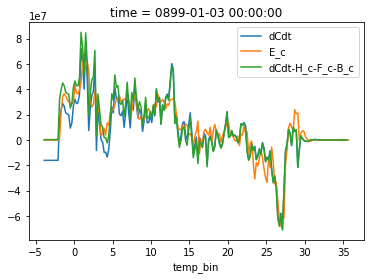

In [82]:
dCdt.plot(label='dCdt')
E_c.plot(label='E_c')
# H_c.plot(label='H_c')
# F_c.plot(label='F_c')
# B_c.plot(label='B_c')
(dCdt-H_c-F_c-B_c).plot(label='dCdt-H_c-F_c-B_c')
plt.legend()

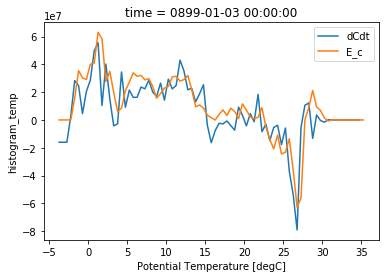

In [77]:
dCdt.plot(label='dCdt')
E_c.plot(label='E_c')
# H_c.plot(label='H_c')
# F_c.plot(label='F_c')
# B_c.plot(label='B_c')
# (dCdt-H_c-F_c-B_c).plot(label='dCdt-H_c-F_c-B_c')
plt.legend()

In [44]:
l = ds['temp_snap']
delta_l = 0.5
l_i_vals = np.arange(-4,36,delta_l)
p = rho0*ds['o2_snap']*ds['thkcello_snap']
area = grid.areacello
# RANGE MUST INCLUDE ALL POSSIBLE VALUES OF l
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
nanmask = np.isnan(l)
# Integrate p in each bin
P_l = histogram(l.where(~nanmask),bins=[l_l_vals],weights=(p*area).where(~nanmask),dim=['xh','yh','zl'],block_size=1)
# Cumulatively sum
P = (P_l.sum(l.name+'_bin')-P_l.cumsum(l.name+'_bin')).assign_coords({l.name+'_bin':l_l_vals[:-1]})

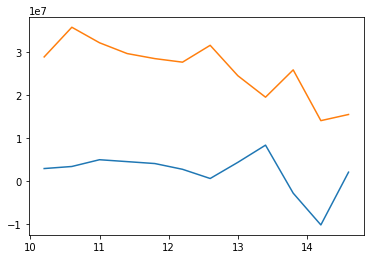

In [106]:
plt.plot(A['temp_bin'],A)
plt.plot(E['temp_bin'],E)

### Evaluate terms for a single temperature contour

In [23]:
l = ds['temp'].isel(time=1)
dl = dheat.isel(time=1)/cp
c = ds['o2'].isel(time=1)
dc = ds[o2_terms].isel(time=1)
area = grid.areacello
c_snap = ds['o2_snap']
l_snap = ds['temp_snap']
h_snap = ds['thkcello']

delta_l = 0.2

for l_l in [25]:
    l_i_vals = np.array([l_l-delta_l/2,l_l+delta_l/2])
    
    mask_above = l>=l_i_vals[1]
    mask_below = l>=l_i_vals[0]
    mask_on = l>=l_l
    
    # Calculate c content tendency
    mask_on_snap = l_snap>=l_l
    C = (c_snap*h_snap*area).where(mask_on_snap,0).sum(['xh','yh','zl'])
    dCdt = C.differentiate('time').isel(time=1)

    # Calculate E as difference of tendency integrated over l>l_i for upper and lower interfaces, divided by width of layer
    # First order finite difference
    cdl_above = (c*dl*area).where(mask_above,0).sum(['xh','yh','zl'])
    cdl_below = (c*dl*area).where(mask_below,0).sum(['xh','yh','zl'])
    E = (cdl_above-cdl_below)/delta_l

    # Calculate integrated diffusive tendencies of tracer, c, for l>l_l
    dc_on = (dc*area).where(mask_on,0).sum(['xh','yh','zl'])

    dc_on_adv = dc_on['o2_advection_xy']+dc_on['o2h_tendency_vert_remap']
    dc_on_diff = dCdt-dc_on['o2_dfxy_cont_tendency']-dc_on['o2_vdiffuse_impl']-dc_on['jo2']

    print('l_l: '+str(l_l))
    print('E(l_l)            = '+str(E.values))
    print('[C_adv(l_l)]      = '+str(dc_on_adv.values))
    print('[C_tend]-[C_diff] = '+str(dc_on_diff.values))
    print(' ')

l_l: 25
E(l_l)            = 34312726.70552276
[C_adv(l_l)]      = 12757345.662104353
[C_tend]-[C_diff] = -845075.5884645283
 


In [104]:
l = ds['temp']
dl = dheat/cp
c = ds['o2']
dc = ds[o2_terms]
area = grid.areacello
l_l = 12

for delta_l in [0.1,0.5,1,2]:
    l_i_vals = np.array([l_l-delta_l/2,l_l+delta_l/2])
    
    mask_above = l>=l_i_vals[1]
    mask_below = l>=l_i_vals[0]
    mask_on = l>=l_l

    # Calculate E as difference of tendency integrated over l>l_i for upper and lower interfaces, divided by width of layer
    # First order finite difference
    cdl_above = (c*dl*area).where(mask_above,0).sum()
    cdl_below = (c*dl*area).where(mask_below,0).sum()
    E = (cdl_above-cdl_below)/delta_l

    # Calculate integrated diffusive tendencies of tracer, c, for l>l_l
    dc_on = (dc*area).where(mask_on,0).sum()

    dc_on_adv = dc_on['o2_advection_xy']+dc_on['o2h_tendency_vert_remap']
    dc_on_diff = dc_on['o2h_tendency']-dc_on['o2_dfxy_cont_tendency']-dc_on['o2_vdiffuse_impl']-dc_on['jo2']

    print('delta_l: '+str(delta_l))
    print('E(l_l)            = '+str(E.values))
    print('[C_adv(l_l)]      = '+str(dc_on_adv.values))
    print('[C_tend]-[C_diff] = '+str(dc_on_diff.values))
    print(' ')

delta_l: 0.1
E(l_l)            = -30051835.288756415
[C_adv(l_l)]      = 4261264.129029352
[C_tend]-[C_diff] = 4261264.129029326
 
delta_l: 0.5
E(l_l)            = -27776684.578672487
[C_adv(l_l)]      = 4261264.129029352
[C_tend]-[C_diff] = 4261264.129029326
 
delta_l: 1
E(l_l)            = -28807856.975569185
[C_adv(l_l)]      = 4261264.129029352
[C_tend]-[C_diff] = 4261264.129029326
 
delta_l: 2
E(l_l)            = -29698673.31078244
[C_adv(l_l)]      = 4261264.129029352
[C_tend]-[C_diff] = 4261264.129029326
 


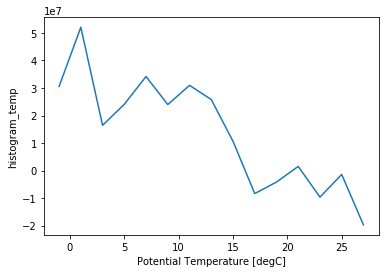

In [46]:
c = ds['o2']
l = ds['temp']
dl = dheat/cp
l_i_vals = np.arange(-2,30,2)

# l = ds['rhopot2'].where(ds.yh<-30,drop=True)
# dl = drho.where(ds.yh<-30,drop=True)
# l_i_vals = np.arange(1028,1038,0.4)

area = grid.areacello#.where(ds.yh<-30,drop=True)

E = calc_E(c.squeeze(),l.squeeze(),dl.squeeze(),l_i_vals,area,plot=False)

In [49]:
sumofterms = ds['o2h_tendency']+ds['o2_dfxy_cont_tendency']+ds['o2_vdiffuse_impl']+ds['jo2']
l = ds['temp']
l_i_vals = np.arange(-2,30,2)

l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
A_vals = np.zeros(shape=(len(l_l_vals),len(sumofterms['time'])))
for i in range(len(l_l_vals)):
    print(i)
    mask = l<=l_l_vals[i]
    A_vals[i] = (sumofterms*area).where(mask,0).sum(['xh','yh','zl'])
A = xr.DataArray(A_vals,dims=['l_l','time'],coords={'l_l':l_l_vals,'time':sumofterms['time']})
    
# calc_A(sumofterms,l,l_i_vals,area,plot=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


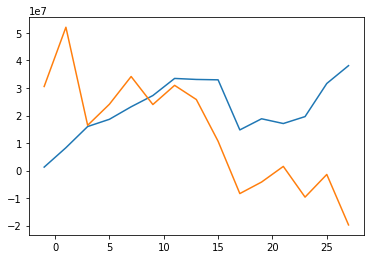

In [50]:
t=11
plt.plot(A['l_l'],(-1*A),'-')
plt.plot(E['temp_bin'],E,'-')

In [5]:
def calc_E(ds,l,l_i_vals,dl,c,area,z='depth',xdim='xh',ydim='yh',zldim='zl',zidim='zi',binning=None):
    '''Evaluation of the transport of tracer [c] across contours of tracer [l]
    l and c should be given as strings and both be contained in Dataset ds
    dl corresponds to the diffusive time tendency of tracer *content* of l,
    i.e. the tendency of rho*l*h where h is layer thickness, and rho is in situ
    density, thus in units of [kg m^-3]*[l tracer unit]*[m]*[s-1].
    Then
        E(l') = \frac{1}{\Delta l}\iint_{l=l'} c*dl dA
    This uses the fact that the tracer content tendency is equal to the 
    rho * tracer tendency integrated within a layer (which is formulation for
    wmt in Groeskamp et al, 2019).'''
    
    E = xr.Dataset()
    
    # Calculate tracer at layer centres from interface values
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    # Calculate delta_tracer for each layer
    delta_l_vals = np.diff(l_i_vals)
    # Place in DataArrays
    l_i=xr.DataArray(l_i_vals,dims=['l_i'],coords={'l_i':l_i_vals})
    l_l=xr.DataArray(l_l_vals,dims=['l_l'],coords={'l_l':l_l_vals})
    delta_l = xr.DataArray(delta_l_vals,dims=['l_l'],coords={'l_l':l_l_vals})

    # Calculate cdl
    cdl = ds[c]*dl

    # Bin into layers of l, and sum up across space
    if binning is None:
        work = (cdl*area).sum(dim=[xdim,ydim])
        work = work.rename({vertc:'l_l'})
    if binning=='xhistogram':
        nanmask = np.isnan(cdl)
        work = histogram(
                    ds[l].where(~nanmask), 
                    bins=[l_i.values], 
                    dim=['xh','yh','zl'], 
                    weights=(cdl*area).where(~nanmask),
                    block_size=None
                    )
        work = work.rename({l+'_bin':'l_l'})
    if binning=='busecke':
        l_depth_i = vc.linear_interpolation_regrid(ds[z+'_l'], ds[l], l_i, z_bounds=ds[z+'_i'], target_value_dim='l_i', z_bounds_dim=zidim, z_dim=zldim)
        cdl_remapped = vc.conservative_remap(cdl,z_bnds_source=ds[z+'_i'], z_bnds_target=l_depth_i,
                                           z_dim=zldim, z_bnd_dim=zidim, z_bnd_dim_target='regridded', mask=True)
        work = (cdl_remapped*area).sum(dim=[xdim,ydim])
        work = work.rename({'remapped':'l_l'})
        E['l_depth_i'] = l_depth_i
    
    E['E'] = work/delta_l
    E['dE']= E['E'].interp(l_l=l_i,method='linear').diff('l_i').assign_coords(l_i=l_l.values).drop('l_l').rename({'l_i':'l_l'})
    
    return E

In [26]:
l = 'rhopot2'
l_i_vals = rho2_i.values #np.arange(-2,30,2)#
dl = drho
c = 'ones'
ds['ones']=xr.ones_like(ds['o2'])

### Attempt using xhistogram directly

In [7]:
ds_new = ds[o2_terms]
prof = rb.total_rebin_layerintegral(ds_new,
                                    bin_data = ds[l],
                                    bins=l_i_vals,
                                    dim = ['xh','yh','zl'],
                                    area = grid.areacello,
                                    block_size=None,
                                    verbose=True)
prof = prof.rename({l+'_bin':'l_l'})

o2h_tendency
o2_advection_xy
o2h_tendency_vert_remap
o2_dfxy_cont_tendency
o2_vdiffuse_impl
jo2


In [8]:
E = calc_E(ds,
           l = l,
           l_i_vals = l_i_vals,
           dl = dl,
           c = 'o2',
           area = grid.areacello,
           binning = 'xhistogram'
          )

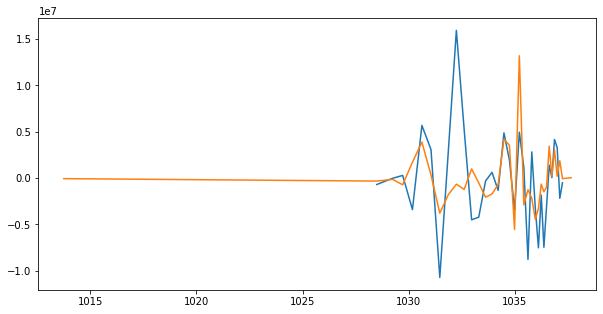

In [9]:
# dE should be equal to the sum of the advective and vertical remap tendencies of o2
LHS = -1*E['dE']#prof['o2h_tendency']
RHS = xr.zeros_like(prof['jo2'])
for term in o2_terms[1:3]:
    RHS += prof[term]
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(LHS['l_l'],LHS)
ax.plot(RHS['l_l'],RHS)
#ax.set_xlim([1028, 1038])

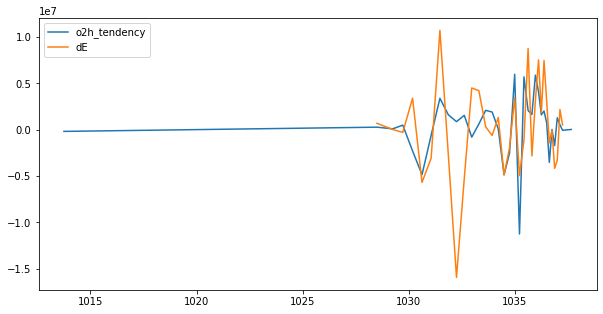

In [12]:
fig,ax = plt.subplots(figsize=(10,5))
signs = [-1,0,0,1,1,1]
count=0
for term in o2_terms[0:1]:
    ax.plot(prof['l_l'],signs[count]*prof[term],label=term)
    count+=1
ax.plot(E['l_l'],E['dE'],label='dE')
ax.legend()
# ax.set_xlim([1028, 1038])

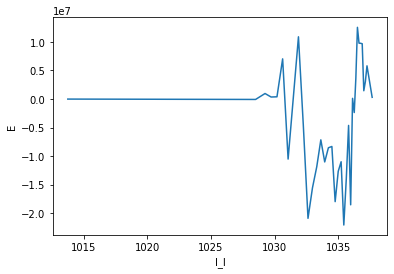

In [13]:
E.E.plot()

### Attempt using jbusecke's regrid/remap functions

In [14]:
# JBusecke xarray utils
# from xarrayutils import vertical_coordinates as vc
# rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
# runname = '6'
# filename = '08990101.ocean_month.nc'
# ds = xr.open_dataset(rootdir+runname+'/history/'+filename)
# Take a subset
ds_now = ds.copy()

# Get the depth of the layers on the native grid
z_i = xr.concat([xr.zeros_like(ds_now['thkcello'].isel(zl=0)),ds_now['thkcello'].cumsum(dim='zl')],dim='zl')
z_i = z_i.rename({'zl':'zi'})
z_i_vals = z_i.values
z_l_vals = 0.5*(z_i_vals[:,:,:-1]+z_i_vals[:,:,1:])
z_l = xr.DataArray(z_l_vals,dims=['yh','xh','zl'],coords={'xh':z_i.xh,'yh':z_i.yh,'zl':ds_now.zl})

ds_now['depth_i']=z_i
ds_now['depth_l']=z_l

In [15]:
l_i_vals = np.append(rho2_i.values,ds_now['rhopot2'].max(xr.ALL_DIMS).values)
E_b = calc_E(ds_now,l=l,l_i_vals=l_i_vals,dl=dl,c=c,area=grid.areacello,binning='busecke')

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [ ]:
# Bin the advective tendency sum in the same manner
c_advection = ds_now['o2_advection_xy']+ds_now['o2h_tendency_vert_remap']
c_advection_remap = vc.conservative_remap(c_advection,z_bnds_source=ds_now['depth_i'], z_bnds_target=E['l_depth_i'],
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
c_advection_int = (c_advection_remap*grid.areacello).sum(dim=['xh','yh'])

(1028, 1038)

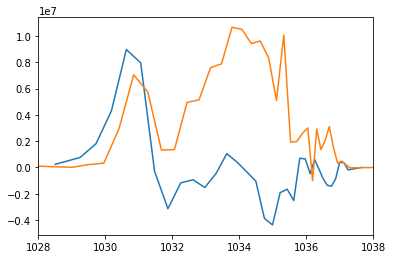

In [22]:
plt.plot(E['l_l'],-1*E['dE'])
plt.plot(l_i_vals[1:],c_advection_int)
plt.gca().set_xlim([1028,1038])

In [16]:
ds_advection = vc.conservative_remap(ds_now['o2_advection_xy'],z_bnds_source=ds_now['depth_i'], z_bnds_target=E_b['l_depth_i'],
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
prof_advection = (ds_advection*grid.areacello).sum(dim=['xh','yh'])

(1028, 1038)

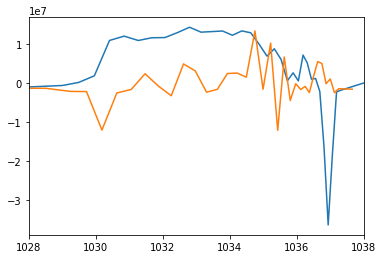

In [33]:
plt.plot(l_i_vals[:-1],prof_advection)
plt.plot(prof['l_l'],prof['o2_advection_xy'])
plt.gca().set_xlim([1028, 1038])

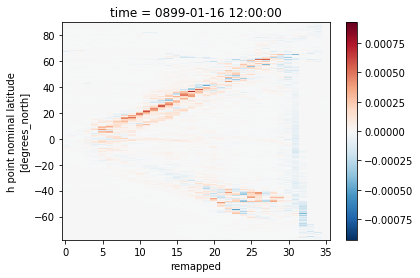

In [37]:
ds_advection.sum('xh').plot()

### See if you can get it to match just for the transport across one layer

In [27]:
E = calc_E(ds,
           l = l,
           l_i_vals = l_i_vals,
           dl = dl,
           c = 'ones',
           area = grid.areacello,
           binning = 'xhistogram'
          )

In [20]:
count=0
div = np.zeros(len(l_i_vals))
for t in l_i_vals:
    div[count] = ((ds['o2_advection_xy']+ds['o2h_tendency_vert_remap']).where(ds['temp']>t,0)*grid['areacello']).sum()
    count+=1


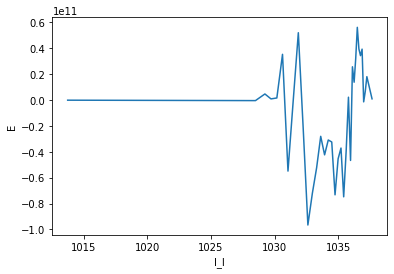

In [28]:
E['E'].plot()
# plt.plot(l_i_vals,div)

In [12]:
div

<xarray.DataArray ()>
array(1014975.03220479)
Coordinates:
    time     object 0899-01-16 12:00:00